In [1]:
# Copyright 2023 Andrew Lehr
# The MIT LICENSE

# # Dynamic control of neural manifolds
#### Lehr, Kumar, & Tetzlaff

####
### Code to produce Supplementary Figure S3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import os

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from scipy.signal import find_peaks
from scipy.signal import hilbert

from submanifolds.utils import get_root
from submanifolds.ringnet.network import RingNetworkVariableSpeed
from submanifolds.ringnet import Parameters
from submanifolds.ringnet import Plot
from submanifolds.utils import get_root

### Color palettes

In [2]:
colors = ['#586ba4', '#f68e5f', '#f5dd90',  
          '#067d7a', '#77c1b3',  '#b63653',
          '#6d2a2a', '#361a1a', '#191414', '#465865', '#928876',
          '#fc9234', '#fd6626', '#44867d', '#177070', '#404a50']

### Directories

In [3]:
root = get_root()
save_figs_flag = 0

# Figure storage
fig_top_dir = root + 'figures/'
fig_dir = fig_top_dir + 'figure_4/'

# Data storage
data_top_dir = root + 'data/'
data_dir = data_top_dir + 'speed_control/'

if not os.path.isdir(fig_top_dir):
    os.mkdir(fig_top_dir)
    print('Created ' + fig_top_dir)
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    print('Created ' + fig_dir)
else:
    print('fig dir exists')

if not os.path.isdir(data_top_dir):
    os.mkdir(data_top_dir)
    print('Created ' + data_top_dir)
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    print('Created ' + data_dir)
else:
    print('data dir exists')

fig dir exists
data dir exists


In [4]:
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

### Parameters

In [5]:
sigma = 0.04
_w_E = 5 
N = 1000
T = 2001 
tau = 100 

n_seeds = 1
seeds = np.arange(n_seeds)

# speed control
speeds = np.arange(1,1000,5).round(2) 
n_speeds = len(speeds)

# asymmetry
shifts = [0.02, 0.04, 0.06]
n_shifts = len(shifts)

# shape control
shapes = [0] 
n_shapes = len(shapes)
t_shape_input = (T-1)/2
sd_shape_input = 12 

# subspaces
p = 0
perc_sel = [p] #np.arange(0).round(2)
n_perc_sel = len(perc_sel)

# shape 2 -- activation function maxima
r_max_vals = [0] #[-0.5,-0.3,0,0.5,1]
n_r_max_vals = len(r_max_vals)
r_max = np.ones((T,N))

active_neurons = np.zeros((n_shifts,n_speeds,n_shapes,n_seeds,T))
average_rate = np.zeros((n_shifts,n_speeds,n_shapes,n_seeds,T))
raster = np.zeros((n_shifts,n_speeds,n_shapes,n_seeds,N,T))

In [6]:
n_speeds * n_shapes * n_perc_sel * n_r_max_vals * n_seeds * n_shifts

600

## Functions

In [7]:
def compute_bump_speed(raster, thr_act = 0, thr_sep = 500):
    N = np.shape(raster)[0]
    T = np.shape(raster)[1]
    bump_center = np.zeros(T)
    pos_cumulative = np.zeros(T)
    for t in range(T):
        neurons_above_thr = np.where(raster[:,t] > thr_act)[0]
        if (np.max(neurons_above_thr) - np.min(neurons_above_thr)) > thr_sep:
            neurons_above_thr[neurons_above_thr<thr_sep] += N
        bump_center[t] = np.mean(neurons_above_thr) % N

    bump_speed = (bump_center[1:] - bump_center[:-1]) % N

    pos_cumulative[0] = bump_center[0]
    for k in range(1,T):
        pos_cumulative[k] = bump_center[0] + np.sum(bump_speed[:k])
    return bump_center, bump_speed, pos_cumulative

## Run simulations

In [8]:
for shift_i, shift in enumerate(shifts):
    for k, seed in enumerate(seeds):
        params_to_update = {'keys':     ['N','sigma_percent', 'shift_percent', 'T', '_w_E', 'p_inh', 'seed', 'stim', 'type'], 
                            'setting':  [N, sigma, shift, T, _w_E, p, seed, 'transient', 'projection']}

        params = Parameters(params_to_update)

        # generate initial condition
        S = speeds[0]*np.ones(T)
        net = RingNetworkVariableSpeed(params, S=S, tau=tau, r_max=r_max) 
        initial_t = 250
        center = 0
        x = net.params.x
        width = int(net.params.sigma)
        max_active = net.params.P * r_max[0]
        initial_r = max_active * np.exp(-0.5 * (x - center)**2 / (width)**2)
        params.initial_r = initial_r
        net.run()
        initial_r = net.R[:,initial_t]
        #plt.plot(initial_r)
        params.initial_r = initial_r

        for j, A in enumerate(shapes):
            I_ext = gaussian(np.arange(T), A, t_shape_input, sd_shape_input)

            for i, I_E in enumerate(speeds):
                #I_ext = gaussian(np.arange(T), A, t_shape_input, sd_shape_input[i])
                S = I_E*np.ones(T)
                net = RingNetworkVariableSpeed(params, S=S, tau=tau, r_max=r_max, I_ext=I_ext) 
                net.run()
                active_neurons[shift_i,i,j,k,:] = np.sum(net.R > 0, axis=0)
                average_rate[shift_i,i,j,k,:] = np.mean(net.R, axis=0)
                raster[shift_i,i,j,k,:,:] = net.R
    print(p)

/home/andrew/Documents/projects/submanifolds/submission_dynamic_control/code/submanifolds/ringnet/parameters.py:66: UserWarning: Recurrent weights were rescaled due to selective inhibition and transient excitatory burst input.
  warnings.warn('Recurrent weights were rescaled due to selective inhibition and transient excitatory burst input.')


0
0
0


### Plot example rasters

In [9]:
plot = Plot()

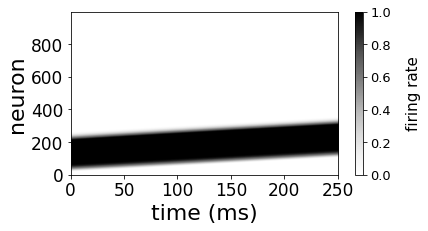

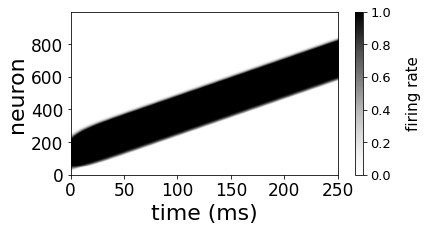

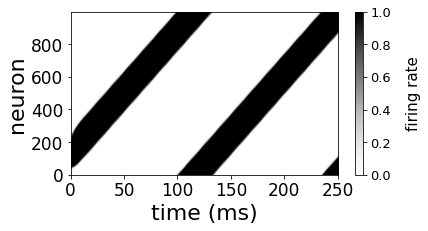

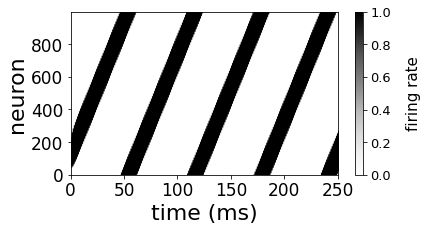

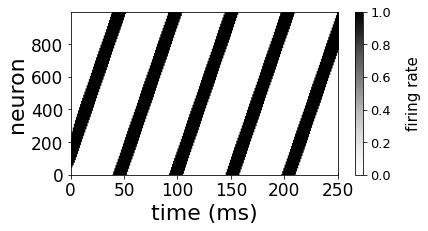

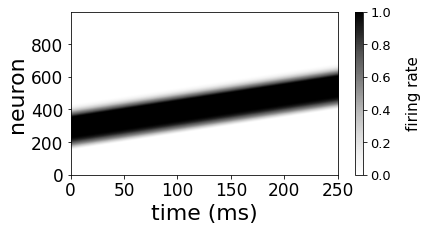

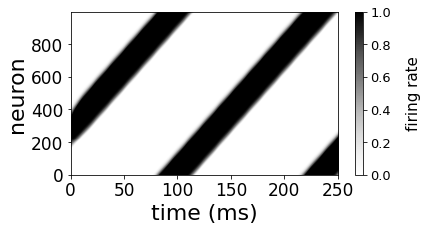

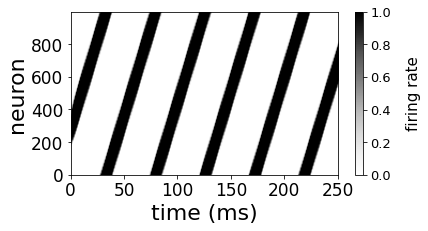

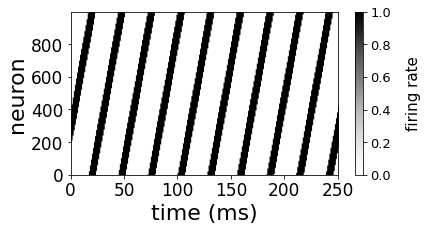

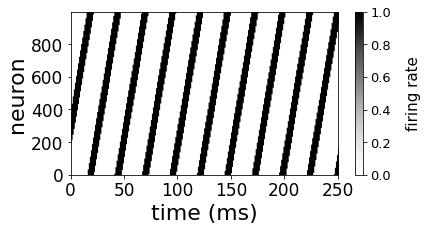

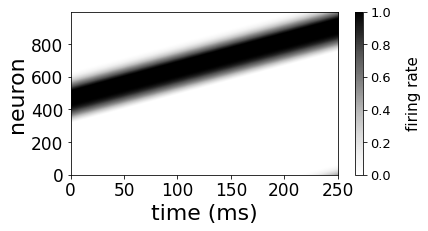

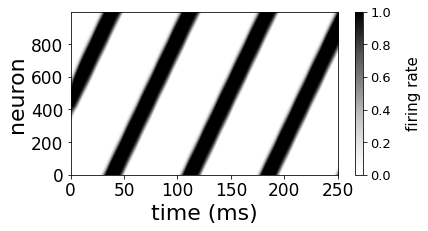

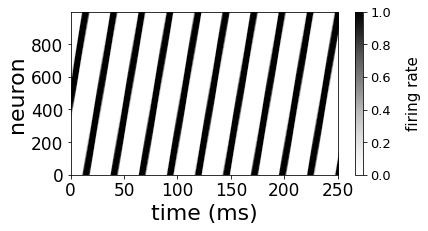

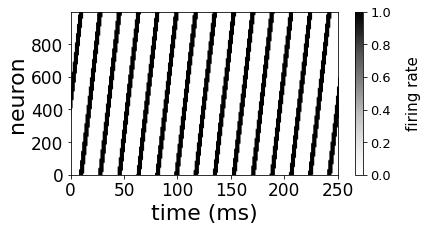

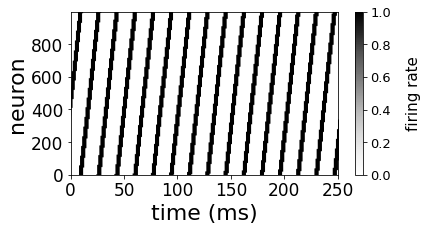

In [10]:
fname='raster_S='
speed_exs = [0,2,10,50,199]
shift_exs = [0,1,2]
perc = 0
traj = 0
seed = 0
for shift_i, shift in enumerate(shift_exs):
    for speed_i, speed in enumerate(speed_exs):
        file = fig_dir+fname+str(speed+1) + '_shift=' + str(shift)
        point = (shift, speed, traj, seed)
        plot.activity_raster(raster[point][:,0:251], xlabel='time (ms)', labelsize=22, storage_loc=file)

In [11]:
centers = np.zeros((n_shifts, n_speeds, T))
pos_cumulative = np.zeros((n_shifts, n_speeds, T))
bump_speed = np.zeros((n_shifts, n_speeds, T-1))
perc = 0
traj = 0
seed = 0
for shift_i, shift in enumerate(shifts):
    for speed_i, speed in enumerate(speeds):
        point = (shift_i, speed_i, traj, seed)
        centers[shift_i, speed_i,:], bump_speed[shift_i, speed_i,:], pos_cumulative[shift_i, speed_i,:] = compute_bump_speed(raster[point])

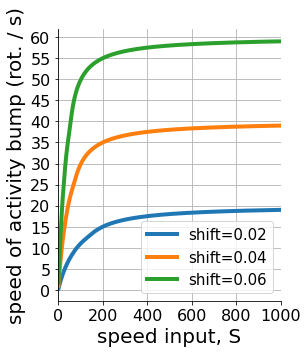

In [12]:
fname='bump_speed_supplement'
fig, ax = plt.subplots(1,1, figsize=(4,5))

for shift_i, shift in enumerate(shifts):
    ax.plot(speeds, bump_speed[shift_i,:,:].mean(axis=1),linewidth=4, label='shift=' + str(shift))
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(np.arange(0,1001,200))
ax.set_xticklabels(np.arange(0,1001,200), fontsize=16)
ax.set_yticks(np.arange(0,65,5).round(1))
ax.set_yticklabels(np.arange(0,65,5).round(1), fontsize=16)
ax.set_xlabel('speed input, S', fontsize=20)
ax.set_ylabel('speed of activity bump (rot. / s)', fontsize=20)
    
ax.set_xlim(-3,1000)
ax.grid()
ax.legend(fontsize=15)

if save_figs_flag:
    plt.savefig(fig_dir+fname+'.png',dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
plt.show()
